In [8]:
!pip install metis
!wget http://glaros.dtc.umn.edu/gkhome/fetch/sw/metis/OLD/metis-5.0.3.tar.gz
!tar -xf metis-5.0.3.tar.gz
!mv metis-5.0.3/* ../content/
!make config shared=1
!make install
%env METIS_DLL=/usr/local/lib/libmetis.so

--2021-02-14 13:35:22--  http://glaros.dtc.umn.edu/gkhome/fetch/sw/metis/OLD/metis-5.0.3.tar.gz
Resolving glaros.dtc.umn.edu (glaros.dtc.umn.edu)... 160.94.40.33
Connecting to glaros.dtc.umn.edu (glaros.dtc.umn.edu)|160.94.40.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4979585 (4.7M) [application/x-gzip]
Saving to: ‘metis-5.0.3.tar.gz.1’

metis-5.0.3.tar.gz. 100%[===================>]   4.75M  5.38MB/s    in 0.9s    

2021-02-14 13:35:24 (5.38 MB/s) - ‘metis-5.0.3.tar.gz.1’ saved [4979585/4979585]

mv: cannot move 'metis-5.0.3/build' to '../content/build': Directory not empty
mv: cannot move 'metis-5.0.3/GKlib' to '../content/GKlib': Directory not empty
mv: cannot move 'metis-5.0.3/graphs' to '../content/graphs': Directory not empty
mv: cannot move 'metis-5.0.3/include' to '../content/include': Directory not empty
mv: cannot move 'metis-5.0.3/libmetis' to '../content/libmetis': Directory not empty
mv: cannot move 'metis-5.0.3/manual' to '../content/manua

In [9]:
import itertools
import pandas as pd
from scipy.special import comb
import numpy as np
import metis
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

In [10]:
class Chameleon():
    def __init__(self):
        self.cmap = plt.get_cmap('viridis')
        self.colors = [self.cmap(i) for i in np.linspace(0, 1, 10)]

    def plot2d_graph(self, graph):
        pos = nx.get_node_attributes(graph, 'pos')
        c = [self.colors[i % (len(self.colors))]
             for i in nx.get_node_attributes(graph, 'cluster').values()]
        if c:  # is set
            nx.draw(graph, pos, node_color=c, node_size=0.25)
        else:
            nx.draw(graph, pos, node_size=0.25)
        plt.show(block=False)

    def plot2d_data(self, df):
        if (len(df.columns) > 3):
            print("Plot Waring: more than 2-Dimensions!")
        df.plot(kind='scatter', c=df['cluster'], cmap='gist_rainbow', x=0, y=1)
        plt.show(block=False)

    def euclidean_distance(self, a, b):
        return np.linalg.norm(np.array(a) - np.array(b))

    def knn_graph(self, df, k, verbose=False):
        points = [p[1:] for p in df.itertuples()]
        g = nx.Graph()
        for i in range(0, len(points)):
            g.add_node(i)
        if verbose:
            print("Building kNN graph (k = %d)..." % (k))
        iterpoints = tqdm(enumerate(points), total=len(
            points)) if verbose else enumerate(points)
        for i, p in iterpoints:
            distances = list(
                map(lambda x: self.euclidean_distance(p, x), points))
            # second trough kth closest
            closests = np.argsort(distances)[1:k+1]
            # print(distances[0])
            for c in closests:
                g.add_edge(i, c, weight=1.0 / distances[c], similarity=int(
                    1.0 / distances[c] * 1e4))
            g.nodes[i]['pos'] = p
        g.graph['edge_weight_attr'] = 'similarity'
        return g

    def part_graph(self, graph, k, df=None):
        
        edgecuts, parts = metis.part_graph(
            graph, 2 , objtype='cut')
        # print(edgecuts)
        for i, p in enumerate(graph.nodes()):
            graph.nodes[p]['cluster'] = parts[i]
        if df is not None:
            df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
        return graph

    def pre_part_graph(self, graph, k, df=None, verbose=False):
        if verbose:
            print("Begin clustering...")
        clusters = 0
        for i, p in enumerate(graph.nodes()):
            graph.nodes[p]['cluster'] = 0
        cnts = {}
        cnts[0] = len(graph.nodes())
        while clusters < k - 1:
            maxc = -1
            maxcnt = 0
            for key, val in cnts.items():
                if val > maxcnt:
                    maxcnt = val
                    maxc = key
            s_nodes = [n for n in graph.nodes if graph.nodes[n]
                       ['cluster'] == maxc]
            s_graph = graph.subgraph(s_nodes)
            edgecuts, parts = metis.part_graph(
                s_graph, 2 , objtype='cut')
            new_part_cnt = 0
            for i, p in enumerate(s_graph.nodes()):
                if parts[i] == 1:
                    graph.nodes[p]['cluster'] = clusters + 1
                    new_part_cnt = new_part_cnt + 1
            cnts[maxc] = cnts[maxc] - new_part_cnt
            cnts[clusters + 1] = new_part_cnt
            clusters = clusters + 1
        
        edgecuts, parts = metis.part_graph(graph, k)
        if df is not None:
            df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
        return graph

    def get_cluster(self, graph, clusters):
        nodes = [n for n in graph.nodes if graph.nodes[n]['cluster'] in clusters]
        return nodes

    def connecting_edges(self, partitions, graph):
        cut_set = []
        for a in partitions[0]:
            for b in partitions[1]:
                if a in graph:
                    if b in graph[a]:
                        cut_set.append((a, b))
        return cut_set

    def min_cut_bisector(self, graph):
        graph = graph.copy()
        graph = self.part_graph(graph, 2)
        partitions = self.get_cluster(graph, [0]), self.get_cluster(graph, [1])
        return self.connecting_edges(partitions, graph)

    def get_weights(self, graph, edges):
        return [graph[edge[0]][edge[1]]['weight'] for edge in edges]

    def bisection_weights(self, graph, cluster):
        cluster = graph.subgraph(cluster)
        edges = self.min_cut_bisector(cluster)
        weights = self.get_weights(cluster, edges)
        return weights


    def external_index(self , v1, v2):
        TP, FN, FP, TN = self.confusion_index(v1, v2)
        RI = (TP + TN) / (TP + FN + FP + TN)
        ARI = 2 * (TP * TN - FN * FP) / ((TP + FN) *
                                        (FN + TN) + (TP + FP) * (FP + TN))
        JI = TP / (TP + FN + FP)
        FM = TP / np.sqrt((TP + FN) * (TP + FP))
        return RI, ARI, JI, FM


    def confusion_index(self , v1, v2):
        cmatrix = self.contingency(v1, v2)
        size = np.size(v1)
        sum_rows = np.sum(cmatrix, 0)
        sum_cols = np.sum(cmatrix, 1)
        N = comb(size, 2)
        TP = np.sum(list(map(lambda x: comb(x, 2), cmatrix)))
        FN = np.sum(list(map(lambda x: comb(x, 2), sum_rows))) - TP
        FP = np.sum(list(map(lambda x: comb(x, 2), sum_cols))) - TP
        TN = N - TP - FN - FP
        return TP, FN, FP, TN


    def contingency(self , v1, v2):
        res = np.zeros((np.max(v1), np.max(v2)))
        for i in range(0, np.size(v1)):
            res[v1[i] - 1, v2[i] - 1] = res[v1[i] - 1, v2[i] - 1] + 1
        return res


    def internal_interconnectivity(self , graph, cluster):
        return np.sum(self.bisection_weights(graph, cluster))


    def relative_interconnectivity(self , graph, cluster_i, cluster_j):
        edges = self.connecting_edges((cluster_i, cluster_j), graph)
        EC = np.sum(self.get_weights(graph, edges))
        ECci, ECcj = self.internal_interconnectivity(graph, cluster_i), self.internal_interconnectivity(graph, cluster_j)
        return EC / ((ECci + ECcj) / 2.0)


    def internal_closeness(self , graph, cluster):
        cluster = graph.subgraph(cluster)
        edges = cluster.edges()
        weights = self.get_weights(cluster, edges)
        return np.sum(weights)


    def relative_closeness(self , graph, cluster_i, cluster_j):
        edges = self.connecting_edges((cluster_i, cluster_j), graph)
        if not edges:
            return 0.0
        else:
            SEC = np.mean(self.get_weights(graph, edges))
        Ci, Cj = self.internal_closeness(graph, cluster_i), self.internal_closeness(graph, cluster_j)
        SECci, SECcj = np.mean(self.bisection_weights(graph, cluster_i)), np.mean(
            self.bisection_weights(graph, cluster_j))
        return SEC / ((Ci / (Ci + Cj) * SECci) + (Cj / (Ci + Cj) * SECcj))


    def merge_score(self , g, ci, cj, a):
        return self.relative_interconnectivity(g, ci, cj) * np.power(self.relative_closeness(g, ci, cj), a)


    def merge_best(self , graph, df, a, k, verbose=False):
        clusters = np.unique(df['cluster'])
        max_score = 0
        ci, cj = -1, -1
        if len(clusters) <= k:
            return False

        for combination in itertools.combinations(clusters, 2):
            i, j = combination
            if i != j:
                if verbose:
                    print("Checking c%d c%d" % (i, j))
                gi = self.get_cluster(graph, [i])
                gj = self.get_cluster(graph, [j])
                edges = self.connecting_edges((gi, gj), graph)
                if not edges:
                    continue
                ms = self.merge_score(graph, gi, gj, a)
                if verbose:
                    print("Merge score: %f" % (ms))
                if ms > max_score:
                    if verbose:
                        print("Better than: %f" % (max_score))
                    max_score = ms
                    ci, cj = i, j

        if max_score > 0:
            if verbose:
                print("Merging c%d and c%d" % (ci, cj))
            df.loc[df['cluster'] == cj, 'cluster'] = ci
            for i, p in enumerate(graph.nodes()):
                if graph.nodes[p]['cluster'] == cj:
                    graph.nodes[p]['cluster'] = ci
                
        return max_score > 0


    def cluster(self , df, k, knn=10, m=30, alpha=2.0, verbose=False, plot=False):
        graph = self.knn_graph(df, knn, verbose=True)
        graph = self.pre_part_graph(graph, m, df, verbose=True)
        iterm = tqdm(enumerate(range(m - k)), total=m-k)
        for i in iterm:
            self.merge_best(graph, df, alpha, k, verbose)
            if plot:
                self.plot2d_data(df)
        res = self.rebuild_labels(df)
        return res


    def rebuild_labels(self , df):
        ans = df.copy()
        clusters = list(pd.DataFrame(df['cluster'].value_counts()).index)
        c = 1
        for i in clusters:
            ans.loc[df['cluster'] == i, 'cluster'] = c
            c = c + 1
        return ans


  1%|          | 8/788 [00:00<00:10, 75.36it/s]

Building kNN graph (k = 20)...


100%|██████████| 788/788 [00:11<00:00, 68.79it/s]


Begin clustering...


  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  3%|▎         | 1/33 [00:03<01:42,  3.19s/it]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  6%|▌         | 2/33 [00:06<01:39,  3.20s/it]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret /

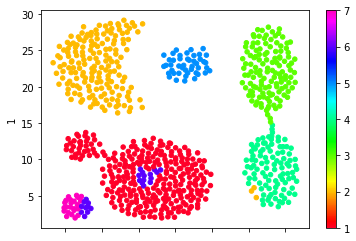

In [11]:
if __name__ == "__main__":
    # get a set of data points
    df = pd.read_csv('/content/drive/MyDrive/Dataset/Aggregation.csv', sep=' ',
                     header=None)

    ChameleonCluster = Chameleon()
    # returns a pands.dataframe of cluster
    res = ChameleonCluster.cluster(df, 7, knn=20, m=40, alpha=2.0, plot=False)

    # draw a 2-D scatter plot with cluster
    ChameleonCluster.plot2d_data(res)